In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set(rc={'axes.titlesize': 16, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})


In [2]:
# Check raw data
war_raw = pd.read_csv('war_1800.csv',header=0)
population_raw = pd.read_csv("population.csv")      
population = population_raw.loc[:,['Year','Population (historical estimates)']][(population_raw['Entity']=='World') & (population_raw['Year']>1799)].copy()
population = population.rename(columns={'Year':'year','Population (historical estimates)':'end_population'})
war_raw

,name,toll_low,toll_high,toll_mid,year_start,year_end,relation
0,World War II,80000000,80000000,80000000,1939,1945,NaN
1,Taiping Rebellion,20000000,70000000,45000000,1850,1864,NaN
2,Second Sino-Japanese War,20000000,25000000,22500000,1937,1945,World War II
3,World War I,17000000,17000000,17000000,1914,1918,NaN
4,Dungan Revolt,8000000,20000000,14000000,1862,1877,NaN
...,...,...,...,...,...,...,...
292,2016 Niger Delta conflict,36,36,36,2016,Present,Conflict in the Niger Delta
293,2017 Afghanistan–Pakistan border skirmish,12,61,36,2017,2017,NaN
294,2023 attacks on U.S. bases in Iraq and Syria,26,26,26,2023,Present,NaN
295,2008 Kufra conflict,11,30,20,2008,2008,NaN


In [3]:
# replace present as Year 2023 case-insensitively
war = war_raw.replace(to_replace=r'(?i)Present', value=2023, regex=True) 

# adjust data type
war[['toll_low','toll_high','toll_mid','year_start','year_end']]=war[['toll_low','toll_high','toll_mid','year_start','year_end']].astype(int) 
war['duration']=war['year_end']-war['year_start']+1

# Merge war with population
war = pd.merge(war, population, how='left', left_on='year_end', right_on='year')
# set status
war['status'] = 'closed'  
war.loc[war['year_end'] == 2023, 'status'] = 'open'

# Compute death tolls over population
war['toll_perc'] = war['toll_mid']*100/war['end_population']

In [4]:
# Filter the relational wars and only leave main ones
# war_unique = war[war['relation'].isnull()]
war_unique = war.copy()


Text(0.5, 1.0, 'Discrepancy: Death Toll vs. Population Growth')

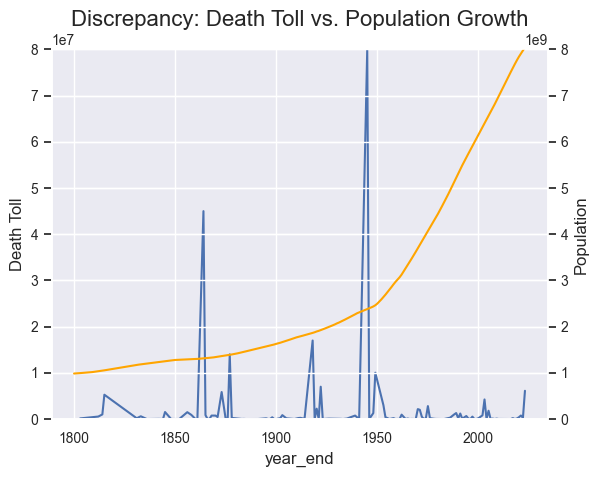

In [5]:

sns.lineplot(war_unique[(war['relation'].isnull())].groupby('year_end').sum()['toll_mid']).set(ylim=(0,8e7), ylabel='Death Toll')
ax2 = plt.twinx()
sns.lineplot(population,x='year',y='end_population',ax=ax2, color='orange').set(ylim=(0,8e9), ylabel='Population')
plt.title('Discrepancy: Death Toll vs. Population Growth')


Text(0.5, 0.98, 'Taiping Rebellion Caused Higher Death Toll Proportion Than WWII.')

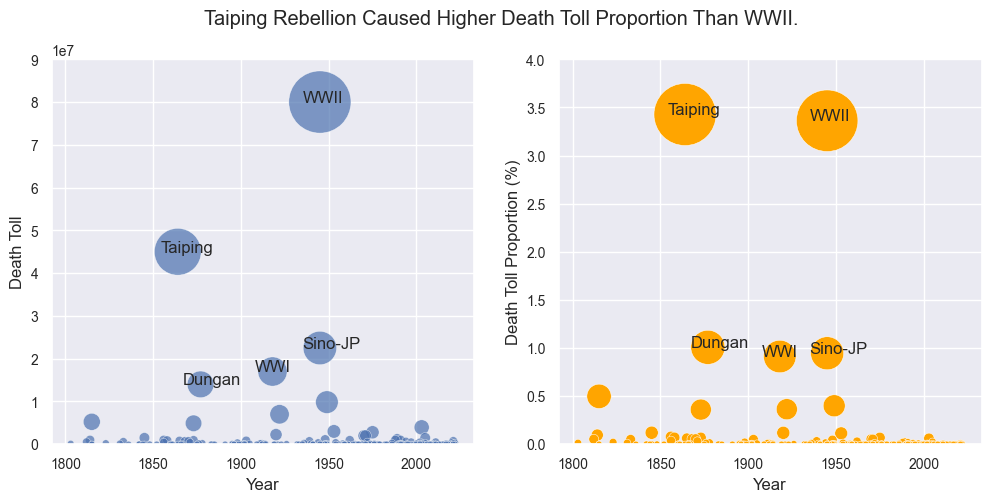

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
# Two bloody war annotations
wars={
    "WWII":'World War II', 
    "Taiping": 'Taiping Rebellion', 
    "WWI":"World War I", 
    "Dungan":"Dungan Revolt",
    "Sino-JP":"Second Sino-Japanese War"}
anns=dict()

# Using Death Toll
sns.scatterplot(
    data=war_unique[war_unique['status']=='closed'], x="year_end", y="toll_mid", size="toll_mid", legend=False, sizes=(20, 2000),ax=axes[0],alpha=0.7
    ).set(
    ylim=(0,9e7),ylabel='Death Toll',xlabel="Year")


# Using Percentage
sns.scatterplot(
    data=war_unique[war_unique['status']=='closed'], x="year_end", y="toll_perc", size="toll_perc", legend=False, sizes=(20, 2000),ax=axes[1],color='orange'
    ).set(
    ylim=(0,4),ylabel='Death Toll Proportion (%)',xlabel="Year"
    )

for key in wars:
    anns[key]=(war_unique.loc[war_unique['name'] == wars[key], 'year_end'].values[0]-10, war_unique.loc[war_unique['name'] == wars[key], 'toll_mid'].values[0])
    axes[0].annotate(key,xy=anns[key], xytext=anns[key])
    anns["{key}_perc"]=(war_unique.loc[war_unique['name'] == wars[key], 'year_end'].values[0]-10, war_unique.loc[war_unique['name'] == wars[key], 'toll_perc'].values[0])
    axes[1].annotate(key,xy=anns["{key}_perc"], xytext=anns["{key}_perc"])

fig.suptitle('Taiping Rebellion Caused Higher Death Toll Proportion Than WWII.') 


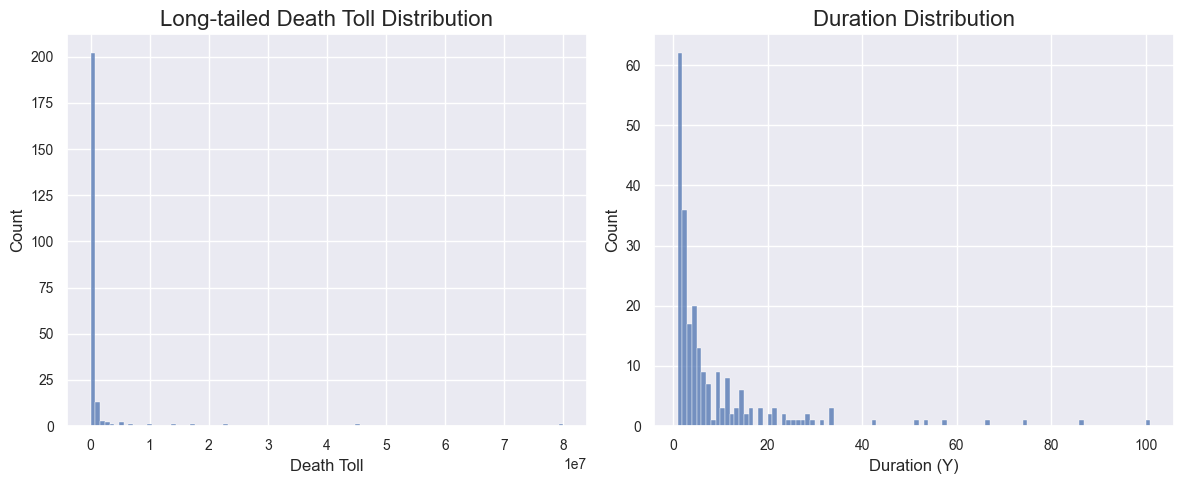

In [7]:
war_closed = war_unique[war_unique['status']=='closed']
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(war_closed['toll_mid'],bins=100,ax=axes[0]).set(title="Long-tailed Death Toll Distribution", xlabel='Death Toll')
sns.histplot(war_closed['duration'],bins=100,ax=axes[1]).set(title="Duration Distribution", xlabel='Duration (Y)')
plt.tight_layout()
plt.show()


In [8]:
# Normalization
war_unique.loc[:, 'toll_percN'] = war_unique['toll_perc']*4 / (war_unique['toll_perc'].max() - war_unique['toll_perc'].min())
war_unique.loc[:, 'durationN'] = war_unique['duration']  / (war_unique['duration'].max() - war_unique['duration'].min())

war_cluster=war_unique[war_unique['status']=='closed'].copy()
X = np.array(war_cluster[['durationN','toll_percN']].values)
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
war_cluster['cluster'] = kmeans.labels_

[Text(0.5, 1.0, 'Clustered Results For Death Toll and Duration'),
 Text(0.5, 0, 'Duration (Y)'),
 Text(0, 0.5, 'Death Toll Proportion (%)')]

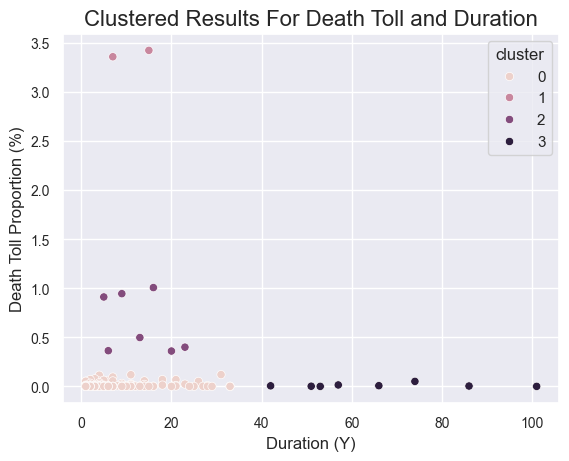

In [9]:
sns.scatterplot(
    data=war_cluster, y='toll_perc',x='duration',hue='cluster'
    ).set(title='Clustered Results For Death Toll and Duration', xlabel='Duration (Y)', ylabel='Death Toll Proportion (%)')

In [10]:
war_cluster.sort_values('duration',ascending=False)

,name,toll_low,toll_high,toll_mid,year_start,year_end,relation,duration,year,end_population,status,toll_perc,toll_percN,durationN,cluster
260,Arab separatism in Khuzestan,206,345,275,1922,2022,NaN,101,2022,7975105156,closed,3.448230e-06,4.025727e-06,0.961905,3
60,Iraqi–Kurdish conflict,138800,320100,229450,1918,2003,NaN,86,2003,6393898496,closed,3.588577e-03,4.189579e-03,0.819048,3
27,French conquest of Algeria,595665,1095665,845665,1830,1903,NaN,74,1903,1665703540,closed,5.076924e-02,5.927187e-02,0.704762,3
86,French colonial campaigns,110000,110000,110000,1830,1895,NaN,66,1895,1571250732,closed,7.000792e-03,8.173258e-03,0.628571,3
65,Carlist Wars,200000,200000,200000,1820,1876,NaN,57,1876,1382443050,closed,1.446714e-02,1.689004e-02,0.542857,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Third Anglo-Afghan War,2751,2751,2751,1919,1919,NaN,1,1919,1878650358,closed,1.464349e-04,1.709593e-04,0.009524,0
192,Dominican War of Independence,3000,3000,3000,1844,1844,NaN,1,1844,1245319917,closed,2.409020e-04,2.812473e-04,0.009524,0
189,1958 Lebanon crisis,3000,3000,3000,1958,1958,NaN,1,1958,2916108032,closed,1.028768e-04,1.201063e-04,0.009524,0
188,War of the Golden Stool,3007,3007,3007,1900,1900,NaN,1,1900,1627883132,closed,1.847184e-04,2.156543e-04,0.009524,0


In [11]:
war_cluster[['duration','cluster','toll_perc']].groupby('cluster').agg(['count','mean']).round(2)

duration        toll_perc      
           count   mean     count  mean
cluster                                
0            213   5.97       213  0.01
1              2  11.00         2  3.39
2              7  13.14         7  0.64
3              8  66.25         8  0.01

|Cluster|Categoty|Count|Mean of Duration|Mean of Death Toll Proportion (%)|
|---|---|---|---|---|
|0|Conflictual|213|5.97|0.01|
|1 |Extreme| 2| 11.00 | 3.39|
|2|Severe|7|13.14|0.64|
3|Protracted|8|66.25|0.01|

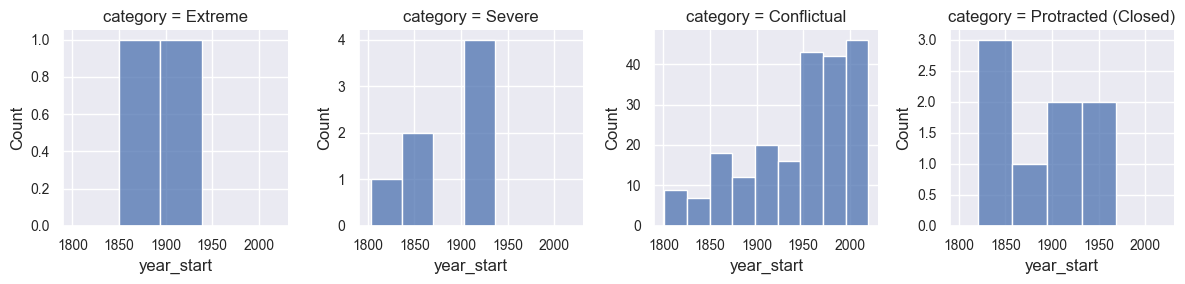

In [12]:
war_cluster['category'] = np.select(
    [(war_cluster['cluster'] == 0),(war_cluster['cluster'] == 1),(war_cluster['cluster'] == 2),(war_cluster['cluster'] == 3)],
    ['Conflictual','Extreme','Severe','Protracted (Closed)'],default='Unknown'
)

g = sns.FacetGrid(war_cluster, col="category", sharey=False)
g.map_dataframe(sns.histplot, x="year_start")

In [13]:
war_cluster[war_cluster['category']=='Extreme']

,name,toll_low,toll_high,toll_mid,year_start,year_end,relation,duration,year,end_population,status,toll_perc,toll_percN,durationN,cluster,category
0,World War II,80000000,80000000,80000000,1939,1945,NaN,7,1945,2380167769,closed,3.361108,3.924013,0.066667,1,Extreme
1,Taiping Rebellion,20000000,70000000,45000000,1850,1864,NaN,15,1864,1313410603,closed,3.426194,4.000000,0.142857,1,Extreme


In [14]:
war_cluster[war_cluster['category']=='Severe']

,name,toll_low,toll_high,toll_mid,year_start,year_end,relation,duration,year,end_population,status,toll_perc,toll_percN,durationN,cluster,category
2,Second Sino-Japanese War,20000000,25000000,22500000,1937,1945,World War II,9,1945,2380167769,closed,0.945312,1.103629,0.085714,2,Severe
3,World War I,17000000,17000000,17000000,1914,1918,NaN,5,1918,1864869126,closed,0.911592,1.064262,0.047619,2,Severe
4,Dungan Revolt,8000000,20000000,14000000,1862,1877,NaN,16,1877,1389974777,closed,1.007213,1.175897,0.152381,2,Severe
5,Chinese Civil War,8000000,11692000,9846000,1927,1949,NaN,23,1949,2463242071,closed,0.399717,0.466660,0.219048,2,Severe
6,Russian Civil War,5000000,9000000,7000000,1917,1922,NaN,6,1922,1924826120,closed,0.363669,0.424575,0.057143,2,Severe
7,Napoleonic Wars,3500000,7000000,5250000,1803,1815,NaN,13,1815,1054586106,closed,0.497826,0.581200,0.123810,2,Severe
8,Miao Rebellion,4900000,4900000,4900000,1854,1873,NaN,20,1873,1360261504,closed,0.360225,0.420554,0.190476,2,Severe


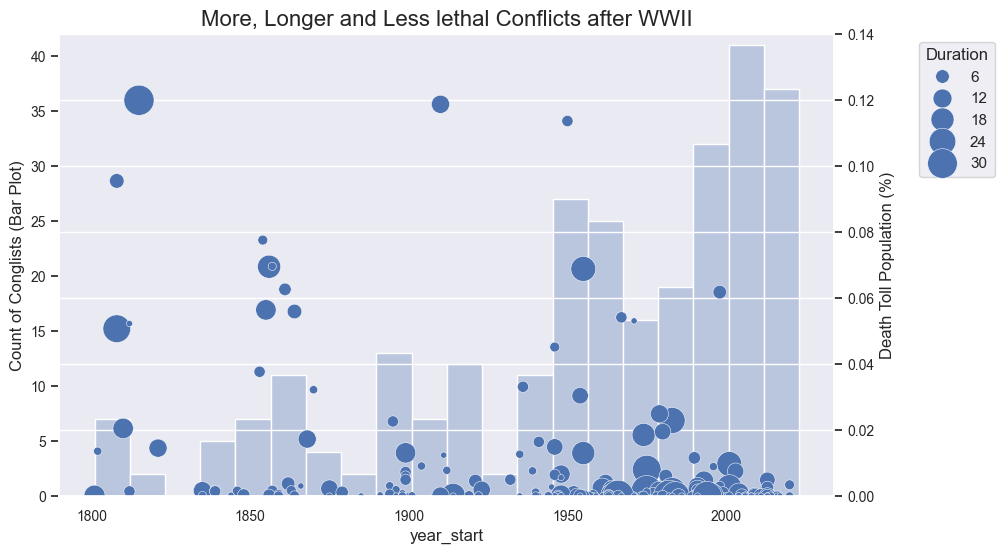

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6))


war_conflicts = pd.concat([war_cluster.loc[war_cluster['category']=='Conflictual','year_start'],war_unique.loc[war_unique['status']=='open','year_start']])
war_conflicts.columns=['year_start']
sns.histplot(data=war_conflicts,bins = 20, alpha=0.3,ax=ax1).set(ylim=(0,42),ylabel='Count of Conglists (Bar Plot)')

ax2 = ax1.twinx()
sns.scatterplot(
    data=war_cluster[war_cluster['category']=='Conflictual'], x="year_start", y="toll_perc", size="duration", sizes=(20, 500),ax=ax2
    ).set(ylim=(0,0.14),ylabel='Death Toll Population (%)',xlabel="Year",title="More, Longer and Less lethal Conflicts after WWII")
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1), title='Duration')
ax1.grid(False)


In [16]:
war_cluster_ww2 =  war_cluster[war_cluster['category']=='Conflictual'].groupby(war_cluster['year_start'] > 1945)[['duration','toll_perc']].mean().round(4)
war_cluster_ww2.index = ['Before 1945', 'After 1945']
war_cluster_ww2.rename(columns={'duration':"Duration",'toll_perc':"Death Toll Proportion"})

,Duration,Death Toll Proportion
Before 1945,5.0513,0.0149
After 1945,6.4963,0.0050


In [17]:
pow((1-2/145),78)

0.33845953071543555

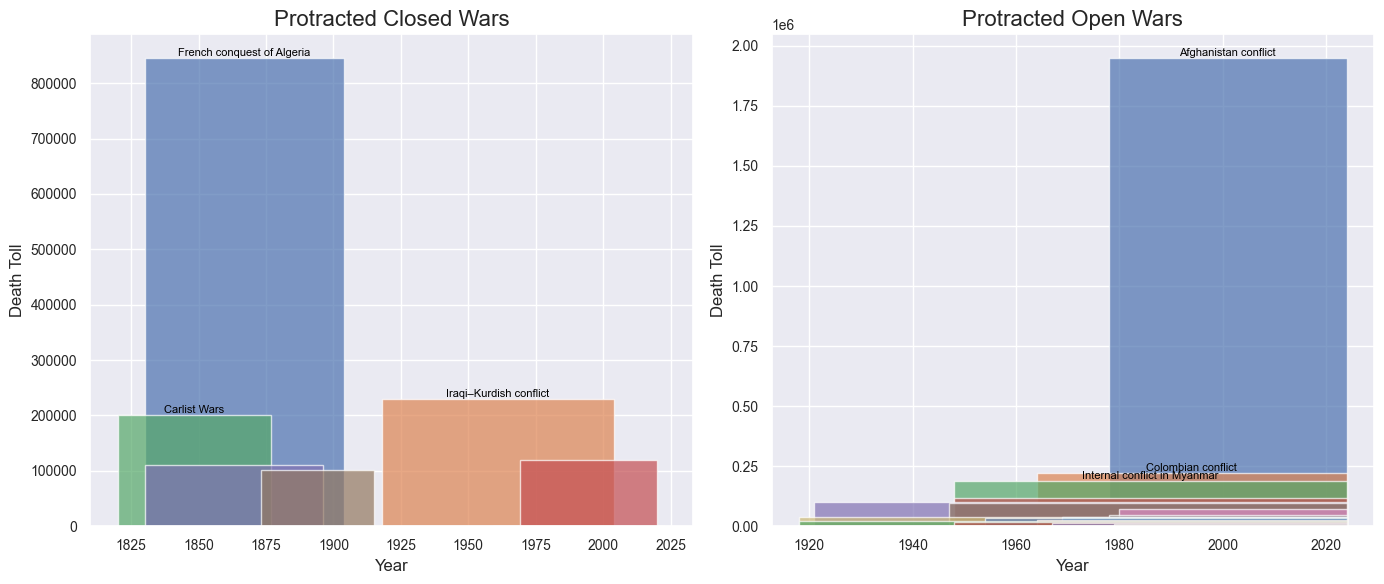

In [18]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

war_protracted_c = war_cluster.loc[war_cluster['category'] == 'Protracted (Closed)',['name','year_start','duration','toll_mid']]
protracted = war_cluster.loc[war_cluster['category'] == 'Protracted (Closed)','duration'].min() # protracted edge
war_protracted_o = war_unique.loc[(war_unique['year_end'] == 2023)&(war_unique['duration'] >protracted),['name','year_start','duration','toll_mid']]

# Protracted Closed Wars
axes[0].set_title('Protracted Closed Wars')
ann = 0
for index, row in war_protracted_c.iterrows():
    start_year = row['year_start']
    duration = row['duration']
    toll_mid = row['toll_mid']
    
    axes[0].bar(x=start_year, height=toll_mid, width=duration, align='edge', alpha=0.7, label=f'War {index + 1}')
    if ann < 3:
        axes[0].text(start_year + duration / 2, toll_mid + 100, row['name'], 
                 ha='center', va='bottom', fontsize=8, color='black')
        ann += 1

# Protracted Open Wars
axes[1].set_title('Protracted Open Wars')
ann = 0
for index, row in war_protracted_o.iterrows():
    start_year = row['year_start']
    duration = row['duration']
    toll_mid = row['toll_mid']
    
    axes[1].bar(x=start_year, height=toll_mid, width=duration, align='edge', alpha=0.7, label=f'War {index + 1}')
    if ann < 3:
        axes[1].text(start_year + duration / 2, toll_mid + 100, row['name'], 
                 ha='center', va='bottom', fontsize=8, color='black')
        ann += 1

# Set common labels
for ax in axes:
    ax.set_xlabel('Year')
    ax.set_ylabel('Death Toll')

plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Start Year Distribution of Open Wars'), Text(0.5, 0, 'Year')]

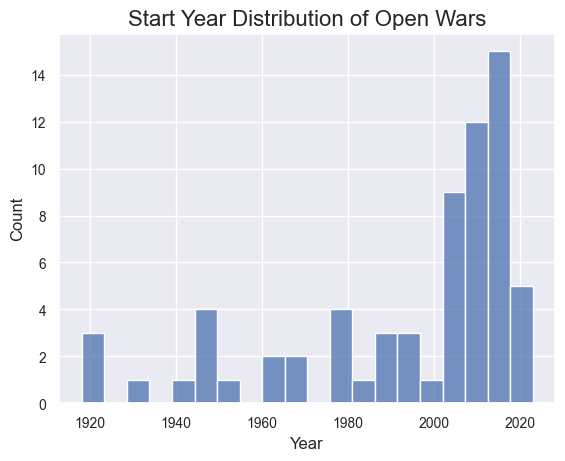

In [19]:
sns.histplot(war_unique[war_unique['year_end'] == 2023],x='year_start',bins=20).set(title='Start Year Distribution of Open Wars', xlabel='Year')

In [20]:
import math

# Average rate of events per year
lambda_rate = 9/145
print(lambda_rate)
# Time interval
time_interval = 2050-1945

# Calculate the probability of no event
math.exp(-lambda_rate * time_interval)

0.06206896551724138


0.0014777400088913264

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Possibility (%)'),
 Text(0.5, 1.0, 'Likelihood of Bloody War Occurring Based on Bernoulli distribution')]

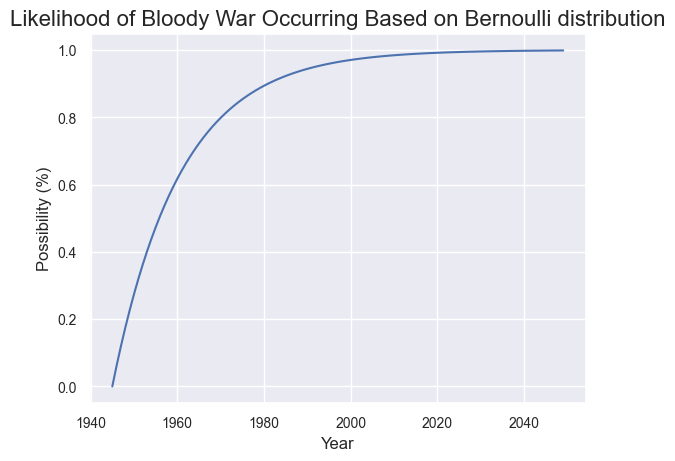

In [25]:
s = np.random.poisson(9/145, 10000)
x=range(0,2050-1945)
y=[pow(1-9/145,x) for x in x]
sns.lineplot(x=[x+1945 for x in x],y=[1-y for y in y]).set(xlabel='Year', ylabel='Possibility (%)',title="Likelihood of Bloody War Occurring Based on Bernoulli distribution")

In [22]:
war_conflicts[war_conflicts.values>1989].describe()

count     110.000000
mean     2006.190909
std         9.183647
min      1990.000000
25%      1998.000000
50%      2009.000000
75%      2013.000000
max      2023.000000
Name: year_start, dtype: float64

[Text(0.5, 1.0, 'Likelihood of Number of Wars Per Year After 1989 Based on Poisson Distribution'),
 Text(0.5, 0, 'Number of Wars'),
 Text(0, 0.5, 'Probability (%)')]

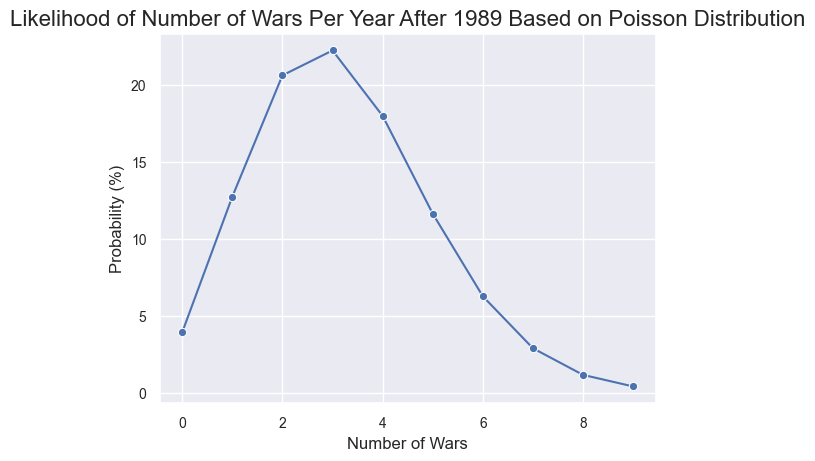

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from math import exp, factorial

def poisson_probability(lam, k):
    return (exp(-lam) * lam**k) / factorial(k)

lambda_one_year = 110/(2023-1989)

counts = np.arange(0, 10)  
probabilities = [poisson_probability(lambda_one_year, k)*100 for k in counts]

sns.lineplot(x=counts, y=probabilities, marker='o', linestyle='-', color='b').set(title='Likelihood of Number of Wars Per Year After 1989 Based on Poisson Distribution', xlabel="Number of Wars", ylabel="Probability (%)")



In [24]:
100-sum(probabilities[:3])

62.74134038057617